# VAE on the MNIST dataset

### Download data

In [0]:
!wget -O train-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz # download train images
!wget -O train-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz # download train labels
!wget -O t10k-images-idx3-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz # download val images
!wget -O t10k-labels-idx1-ubyte.gz http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz # download val labels

!mkdir datasets # create dataset dir
!mkdir datasets/mnist # create mnist dir

# extract downloaded data
!gunzip train-images-idx3-ubyte.gz
!gunzip train-labels-idx1-ubyte.gz
!gunzip t10k-images-idx3-ubyte.gz
!gunzip t10k-labels-idx1-ubyte.gz

# move extracted data to mnist dir
!mv train-images-idx3-ubyte datasets/mnist
!mv train-labels-idx1-ubyte datasets/mnist
!mv t10k-images-idx3-ubyte datasets/mnist
!mv t10k-labels-idx1-ubyte datasets/mnist

--2020-05-15 18:16:14--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 104.28.7.204, 2606:4700:3031::681c:6cc, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  30.2MB/s    in 0.3s    

2020-05-15 18:16:15 (30.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2020-05-15 18:16:16--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.28.6.204, 104.28.7.204, 2606:4700:3031::681c:6cc, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.28.6.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===============

In [0]:
!pip install python-mnist # install mnist helper package

### Imports

In [0]:
import numpy as np # numpy for matrix opreations
import math # math for mathematical operations
import scipy.io # scipy for visualization
import matplotlib.pyplot as plt # matplotlib for plotting

# keras modules
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ReLU
from keras.losses import MSE, KLDivergence
from keras.optimizers import Adam

# efficient tensor operations
import tensorflow as tf

# tensor operations
import tensorflow.keras.backend as K

# distribution visualization
import seaborn as sns

# for plotting normal distribution
from scipy.stats import norm

# display images with PIL
from PIL import Image

# for acessing files
import os

# mnist helper package
from mnist import MNIST

### Read and organize data

In [0]:
mnist = MNIST('datasets/mnist') # load dataset

images, _ = mnist.load_training() # load train images
val_images, _ = mnist.load_testing() # load val images

images = [img.reshape(28, 28) for img in images] # reshape images
val_images = [img.reshape(28, 28) for img in images]

images = np.array(images) # transform list of images to numpy array
val_images = np.array(val_images) # transform list of val images to numpy array

images_temp = np.expand_dims(images, 3) # reshape dataset for training
val_images_temp = np.expand_dims(val_images, 3)

images = np.zeros((images.shape[0], 32, 32, 1)) # pad images to 32x32 px
images[:, 2:30, 2:30, :] = images_temp

val_images = np.zeros((val_images.shape[0], 32, 32, 1))
val_images[:, 2:30, 2:30, :] = val_images_temp

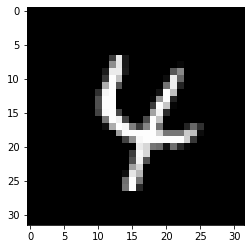

In [0]:
plt.imshow(images[142,:,:,0], cmap="gray") # display sample image

### Normalize data

In [0]:
avg = np.average(images) # calculate mean pixel value in the dataset
std = np.std(images) # calculate std of pixel values in the dataset

images_downscaled  = (images - avg) / std # normalize data using std normalization
val_images_downscaled = (val_images - avg) / std

### VAE encoder loss formula
Using the Kullback-Leibler loss formula.

In [0]:
# KL loss formula
def vae_loss(X, Y): #  Y must be torch.zeros
  X += Y # this line keeps autograd error messages away
  loss = 0 # initialize loss variable
  for i in range(X.shape[1]): # iterate over all possible pixel locations
    for j in range(X.shape[2]):
      for k in range(X.shape[3]):
        mean = K.mean(X[:,i,j,k]) # calculate mean and std of pixel location
        std = K.std(X[:,i,j,k])
        loss += mean*mean+std*std-1-K.log(std*std) # try to minimize the above values using the KL loss formula
  return loss

### Define model

In [0]:
# encoder part
class Encoder():
    # arguments: number of conv levels, number of layers per level, thickness of layers, kernel size
    def __init__(self, levels, layers, thickness, n):
        super(Encoder, self).__init__()
        self.levels = levels
        self.layers = layers
        self.n = n
        self.thickness = thickness
        self.__built = False

    # this method builds the encoder
    # automatically called on first forward pass or summary
    def __build(self, X):
        self.__model = Sequential() # sequetnial model
        for level in range(self.levels): # calculate convolutional layer sizes and create the layers
            for layer in range(self.layers):
                if level == 0 and layer == 0:
                    self.__model.add(Conv2D(self.thickness*(2**level), kernel_size=(self.n, self.n), padding="same", input_shape=X.shape[1:4], name=f"encoder_conv{level}_{layer}"))
                else:
                    self.__model.add(Conv2D(self.thickness*(2**level), kernel_size=(self.n, self.n), padding="same", name=f"encoder_conv{level}_{layer}"))
                self.__model.add(ReLU(name=f"encoder_relu{level}_{layer}")) # relu to avoid loss of gradient
            self.__model.add(MaxPooling2D(pool_size=(2,2), name=f"encoder_maxpool{level}")) # maxpool reduces dimensionality
        self.__model.add(Conv2D(self.thickness*2**(self.levels-1), kernel_size=(self.n, self.n), padding="same", name=f"encoder_final_conv"))
        self.__model.compile(loss=vae_loss, optimizer=Adam(lr=0.001)) # apply KL loss
        self.__built=True

    # forward pass
    # __call__ should be called instead
    def forward(self, X, Y_target):
        if not self.__built:
            self.__build(X)
        loss = self.__model.train_on_batch(X, Y_target)
        return loss
    
    # print model summary
    def summary(self):
        assert self.__built, "Build model first by passing a tensor to it."
        self.__model.summary()

    # forward pass, no training is performed    
    def predict(self, X):
        if not self.__built:
            self.__build(X)
        return self.__model.predict(X)

    # set trainability of network (does not require rebuild)
    def trainable(self, val):
        if not self.__built:
            self.__build(X)
        for layer in self.__model.layers:
            layer.trainable = val
    
    # return inner model
    def model(self):
        return self.__model

# decoder part    
class Decoder():
   
    # parameters: number of conv levels, layers per level, thickness of each level, kernel size
    def __init__(self, levels, layers, thickness, n):
        super(Decoder, self).__init__()
        self.levels = levels
        self.layers = layers
        self.n = n
        self.thickness = thickness
        self.__built = False

    # this method builds the decoder
    # automatically called on first forward pass or summary
    def __build(self, X):
        self.__model = Sequential() # sequetnial model
        for level in reversed(range(self.levels)): # calculate convolutional layer sizes and create the layers
            for layer in range(self.layers):
                self.__model.add(Conv2D(self.thickness*(2**level), kernel_size=(self.n, self.n), padding="same", name=f"decoder_conv{level}_{layer}"))
                self.__model.add(ReLU(name=f"decoder_relu{level}_{layer}"))  # relu to avoid loss of gradient
            self.__model.add(UpSampling2D(size=(2,2), name=f"decoder_upsampling{level}")) # upsample layer reduces dimensionality
        self.__model.add(Conv2D(1, kernel_size=(self.n, self.n), padding="same", name="final_conv"))
        self.__model.compile(loss=['mse'], optimizer=Adam(lr=0.01)) # apply mse after the final layer
        self.__built = True

    # forward pass
    # __call__ should be called instead
    def forward(self, X, Y_target):
        if not self.__built:
            self.__build(X)
        loss = self.__model.train_on_batch(X, Y_target)
        return loss
    
    # print model summary
    def summary(self):
        assert self.__built, "Build model first by passing a tensor to it."
        self.__model.summary()
    
    # forward pass, no training is performed    
    def predict(self, X):
        if not self.__built:
            self.__build(X)
        return self.__model.predict(X)

    # set trainability of network (does not require rebuild)
    def trainable(self, val):
        for layer in self.__model.layers:
            layer.trainable = val

    # return inner model
    def model(self):
        return self.__model

### Train model

In [36]:
epochs = 100 # number of epochs
batch_size = 50 # we use mini batching

batches = math.ceil(images.shape[0] / batch_size) # calculate number of batches
val_batches = math.ceil(val_images.shape[0] / batch_size)

# shorten training time
# batches = 50
# val_batches = 10

# define parameters for the encoder and decoder
levels = 3 
layers = 3
thickness = 4
n = 3

# instantiate encoder and decoder
encoder = Encoder(levels, layers, thickness, n)
decoder = Decoder(levels, layers, thickness, n)

# pass data through encoder and decoder without training
# this builds the model
X = encoder.predict(images_downscaled[:batch_size])
decoder.predict(X)

# create dummy target for kl loss
kl_zeros = tf.zeros((batch_size,32//(2**levels),32//(2**levels),thickness*2**(levels-1)))

# build combined model
combined = Sequential()
combined.add(encoder.model())
combined.add(decoder.model())
# mse loss and adam optimizer
combined.compile(loss=['mse'], optimizer="adam")

# train modle
for e in range(epochs):
    encoder_loss_total = 0 # initialize encoder loss
    decoder_loss_total = 0 # initialize decoder loss
    
    for b in range(batches): # pass all batches of downscaled data through the network
        print(f"\r{b}/{batches}", end="")
        # firstly create the batch of data and target data
        X = images_downscaled[batch_size*b:batch_size*(b+1)]
        Y_target = images[batch_size*b:batch_size*(b+1)]

        # enable training
        encoder.trainable(True) # this method actually enables training by looping over all layers (defined above)
        decoder.trainable(True)

        encoder_loss_total += encoder.forward(X, kl_zeros) # add batch loss to total
        decoder_loss_total += combined.train_on_batch(X, Y_target)
    
    # print loss
    print(f"\repoch {e} -- enc loss: {encoder_loss_total / (batches*batch_size)} -- dec loss: {decoder_loss_total / (batches*batch_size)}", end=" -- ")

    val_encoder_loss_total = 0 # initialize val encoder loss
    val_decoder_loss_total = 0 # initialize val decoder loss
    for b in range(val_batches):  # pass all batches of downscaled val data through the network

        X = val_images_downscaled[batch_size*b:batch_size*(b+1)]
        Y_target = val_images[batch_size*b:batch_size*(b+1)]

        encoder.trainable(False) # disable training
        decoder.trainable(False)

        val_encoder_loss_total += encoder.forward(X, kl_zeros) # add batch loss to total
        val_decoder_loss_total += combined.train_on_batch(X, Y_target)
    
    # print val loss
    print(f"val enc loss: {val_encoder_loss_total / (val_batches*batch_size)} -- val dec loss: {val_decoder_loss_total / (val_batches*batch_size)}")


epoch 0 -- enc loss: 2.1348834116776785 -- dec loss: 40.0134344136556 -- 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


val enc loss: 0.5100326455434163 -- val dec loss: 22.367041092936198
epoch 1 -- enc loss: 0.4211781610329946 -- dec loss: 18.218313981119792 -- val enc loss: 0.3606152188062668 -- val dec loss: 16.067301935831704
epoch 2 -- enc loss: 0.3268316444714864 -- dec loss: 14.752482780965169 -- val enc loss: 0.30212659258842467 -- val dec loss: 13.818267154947916
epoch 3 -- enc loss: 0.28580781542460126 -- dec loss: 13.076672055053711 -- val enc loss: 0.27442872512340544 -- val dec loss: 12.479541784159343
epoch 4 -- enc loss: 0.2652117079973221 -- dec loss: 11.945367841593425 -- val enc loss: 0.2579233667532603 -- val dec loss: 11.541591158040365
epoch 5 -- enc loss: 0.2525276609102885 -- dec loss: 11.241835117594402 -- val enc loss: 0.24735494592984517 -- val dec loss: 10.991329735310872
epoch 6 -- enc loss: 0.24187154753605525 -- dec loss: 10.763654028320312 -- val enc loss: 0.2378176511923472 -- val dec loss: 10.56101362253825
epoch 7 -- enc loss: 0.23422205923398337 -- dec loss: 10.376243

KeyboardInterrupt: ignored

### Results

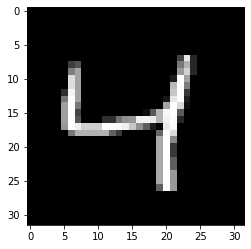

In [37]:
plt.imshow(val_images[2,:,:,0],cmap="gray") # show sample image from the dataset

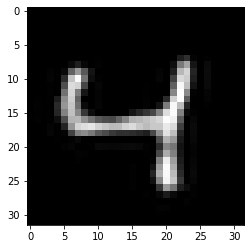

In [38]:
# reproduce the above image
encoded = encoder.predict(val_images_downscaled[2:3]) # pass through encoder and decoder
[pred] = decoder.predict(encoded)
pred = np.array(np.rint(pred), dtype=int)
pred = np.where(pred > 255, 255, pred) # reduce too large pixel values
pred = np.where(pred < 0, 0, pred) # swap negative values for zero
plt.imshow(pred[:,:,0],cmap="gray") # show image

In [0]:
encoded_batch = encoder.predict(val_images_downscaled[:30]) # pass an entire val batch through the model


### Plot encoded data

0.9934868
0.08756098


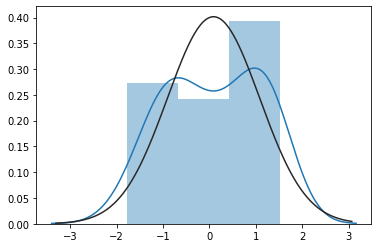

In [40]:
data = encoded_batch[:,0,0,0] # plot distribution of a single pixel
sns.distplot(data, fit=norm) # plot gauss distribution
print(data.std()) # print std and mean of the pixel over the images
print(data.mean())

### Generate images

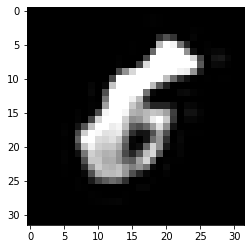

In [115]:
gen_enc = np.random.randn(encoded.shape[0],encoded.shape[1],encoded.shape[2], encoded.shape[3]) # create random compressed image
[pred] = decoder.predict(gen_enc) # generate image from the compressed representation
pred = np.array(np.rint(pred), dtype=int)
pred = np.where(pred > 255, 255, pred) # reduce too large pixel values
pred = np.where(pred < 0, 0, pred) # swap negative values for zero
plt.imshow(pred[:,:,0],cmap="gray") # show image